## Data Load

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.scorer import make_scorer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn import utils
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.manifold import LocallyLinearEmbedding

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings
warnings.filterwarnings("ignore")

In [281]:
raw_data = pd.read_csv('data/qualityData_train.csv')
data = raw_data.copy()
print(data.shape)
data.head()

(3507, 87)


,Time_Sequence,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x77,x78,x79,x80,x81,x82,x83,x84,x85,Y
0,1,0.028837,-0.649824,0.363124,-0.752145,-0.631316,-0.588815,-0.904200,-0.577024,0.715939,...,1.394348,1.350135,1.774360,1.741823,1.705609,-1.175603,0.705534,1.350135,0.625413,2.185269
1,2,0.053882,-0.649824,0.347376,-0.499595,-0.528668,-0.487181,-0.904200,-0.576967,0.702009,...,1.277810,1.404929,1.701051,1.469954,1.705365,-2.588321,0.810728,1.404929,0.050509,1.572313
2,3,0.065778,-0.649824,0.347376,-0.732795,-0.586186,-0.578574,-0.904200,-0.577844,0.703790,...,1.428878,1.573875,1.758069,1.741823,1.705609,-1.371211,0.747611,1.573875,0.625413,2.581797
3,4,0.653070,-1.332022,1.150375,-1.709346,0.473910,1.220860,-0.038151,1.636807,0.448839,...,-0.833474,-1.135911,-0.813025,1.966284,1.263878,-0.059706,-0.511038,-0.885362,0.791103,2.758224
4,6,0.033532,-0.649824,0.389369,-0.440590,-0.605654,-0.545633,-0.904200,-0.577319,0.706495,...,1.433194,1.487119,1.855815,1.741823,1.705609,-1.697222,1.000076,1.487119,0.567923,16.355726


## Outlier Detection

- 상위 0.5% 제거

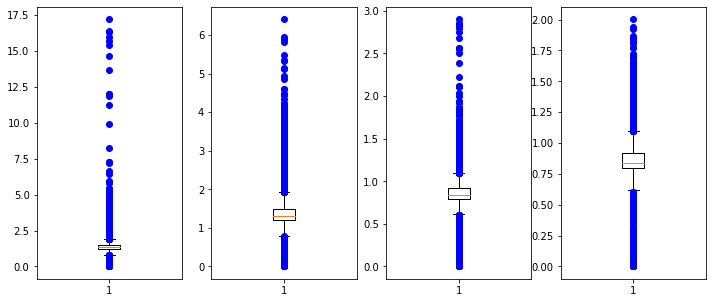

In [149]:
plt.figure(figsize=(12, 5)) 
plt.subplot(1,4,1); plt.boxplot(data['Y'], sym="bo")
plt.subplot(1,4,2); plt.boxplot(data[data.Y < data.Y.quantile(0.995)]['Y'], sym="bo")
plt.subplot(1,4,3); plt.boxplot(np.log1p(data['Y']), sym="bo")
plt.subplot(1,4,4); plt.boxplot(np.log1p(data[data.Y < data.Y.quantile(0.995)]['Y']), sym="bo")
plt.show()

In [282]:
data = data[data.Y < data.Y.quantile(0.995)]
data.reset_index(drop=True, inplace=True)
data.shape

(3489, 87)

## Train / Validation data

- 80% : 20%, RANDOM_SEED = 41

In [151]:
RANDOM_SEED = 41

In [283]:
X_col = data.columns[1:86]
X_train = data[data.columns[:86]]
X0_train = data[X_col]
y_train = data['Y']
print(X_train.shape, X0_train.shape, y_train.shape)

(3489, 86) (3489, 85) (3489,)


## Dimension Reduction

- kernel PCA

In [153]:
def wmae(y, y_pred):
    return sum((y/sum(y))*(np.abs(y-y_pred)))

In [159]:
def GridSearch_kPC(n, X, y):
    clf = Pipeline([
            ("kpca", KernelPCA(random_state=RANDOM_SEED, fit_inverse_transform=True, n_jobs=1)),
            ("reg", LinearRegression())
        ])

    param_grid = [{
            "kpca__n_components": [n],
            "kpca__gamma": np.linspace(0.01, 0.99, 99),
            "kpca__kernel": ["rbf"] #, "sigmoid", "linear", "poly", "cosine"]
        }]

    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=make_scorer(wmae, greater_is_better=False))

    grid_search.fit(X, y)

    pm = grid_search.best_params_
    print(pm)

    rbf_pca = KernelPCA(n_components = pm['kpca__n_components'], kernel=pm['kpca__kernel'], gamma=pm['kpca__gamma'], 
                        fit_inverse_transform=True, n_jobs = 1, random_state = RANDOM_SEED)
    X_kpc = rbf_pca.fit_transform(X)
    X_kpc_inv = rbf_pca.inverse_transform(X_kpc)
    print('WMAE: ', wmae(X, X_kpc_inv))

In [ ]:
GridSearch_kPC(3, X0_train, y_train)

## 최종 X (PC)

In [314]:
mse = []
for n in range(2,21):
    rbf_pca = KernelPCA(n_components = n, kernel="rbf", gamma=0.012, fit_inverse_transform=True)
    X_pc = rbf_pca.fit_transform(X0_train)
    X_pc_inv = rbf_pca.inverse_transform(X_pc)
    mse.append(mean_squared_error(X0_train, X_pc_inv))

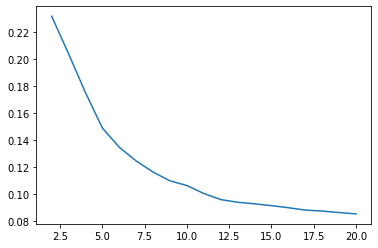

In [332]:
n = np.arange(21)
mse_list = [np.nan, np.nan] + mse
plt.plot(n,mse_list)

In [340]:
rbf_pca = KernelPCA(n_components = 5, kernel="rbf", gamma=0.274, fit_inverse_transform=True)
X_pc = rbf_pca.fit_transform(X0_train)
X_pc_inv = rbf_pca.inverse_transform(X_pc)
mean_squared_error(X0_train, X_pc_inv)

0.3955572634513758

In [311]:
'''rbf_pca = KernelPCA(n_components = 10, kernel="rbf", gamma=0.011, fit_inverse_transform=True)
X_pc = rbf_pca.fit_transform(X0_train)
X_pc_inv = rbf_pca.inverse_transform(X_pc)
mean_squared_error(X0_train, X_pc_inv)'''

0.10530485041170284

In [359]:
X_train = pd.concat([data['Time_Sequence'], pd.DataFrame(X_pc_inv)], axis=1)
X_train.shape

(3489, 86)

In [360]:
y_train = data['Y']
y_train.shape

(3489,)

## Ensemble

In [318]:
def get_cv_score(models, X, y):
    kfold = KFold(n_splits=5, random_state=RANDOM_SEED).get_n_splits(X) # X.values
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X, y)), kf=kfold))
        
def print_best_params(model, params, X, y, wmae=True):
    if wmae == True:
        scorer = make_scorer(wmae, greater_is_better=False)
    else:
        scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring= scorer)
    
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 \n 최적 평균 RMSE 값 {1} \n 최적 alpha:{2} \n '.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [361]:
xgb_params ={
    'max_depth':np.arange(10,100,10),
    'n_estimators':np.arange(100,600,100)
}

xgb_model = xgb.XGBRegressor(seed=RANDOM_SEED, eta=0.01, max_depth=20, subsample=0.8, colsample_bytree=0.5, silent=True, 
                             gpu_id=0,predictor='gpu_predictor', refit=True, learning_rate=0.05, n_jobs=2)
xgb_estimator = print_best_params(xgb_model, xgb_params, X_train, y_train, wmae=False)

XGBRegressor 5 CV 시 
 최적 평균 RMSE 값 0.964 
 최적 alpha:{'max_depth': 10, 'n_estimators': 100} 
 


In [67]:
xgb_params ={
    'n_estimators':np.arange(10,100,5)
}

xgb_model = xgb.XGBRegressor(seed=RANDOM_SEED, eta=0.01, learning_rate=0.05, subsample=0.8, colsample_bytree=0.5, silent=True, 
                             gpu_id=0,predictor='gpu_predictor', refit=True)
xgb_estimator = print_best_params(xgb_model, xgb_params, X_train, y_train, wmae=False)

XGBRegressor 5 CV 시 
 최적 평균 RMSE 값 0.964 
 최적 alpha:{'max_depth': 10, 'n_estimators': 10} 
 


In [362]:
lgb_params = {
#    'num_leave' : np.arange(1,11),
#    'learning_rate' : [0.05, 0.01, 0.005],
    'n_estimators':np.arange(100,600,100)
#    'max_bin' : np.arange(10,100,10)
}

lgb_model = lgb.LGBMRegressor(seed=RANDOM_SEED, objective='regression', gpu_id=0, tree_method='gpu_hist',
                              predictor='gpu_predictor',refit=True, num_leave=10, learning_rate=0.01, max_bin=20)
lgb_estimator = print_best_params(lgb_model, lgb_params, X_train, y_train, wmae=False)

LGBMRegressor 5 CV 시 
 최적 평균 RMSE 값 0.5686 
 최적 alpha:{'n_estimators': 100} 
 


In [69]:
lgb_params = {
    'num_leave' : np.arange(1,6),
    'n_estimators':np.arange(300,400,10),
    'max_bin' : np.arange(10,30,5)
}

lgb_model = lgb.LGBMRegressor(seed=RANDOM_SEED, learning_rate=0.005,objective='regression', gpu_id=0, tree_method='gpu_hist', predictor='gpu_predictor',refit=True)
lgb_estimator = print_best_params(lgb_model, lgb_params, X_train, y_train, wmae=False)

LGBMRegressor 5 CV 시 
 최적 평균 RMSE 값 0.5241 
 최적 alpha:{'max_bin': 20, 'n_estimators': 390, 'num_leave': 1} 
 


In [363]:
xgb_model = xgb.XGBRegressor(seed=RANDOM_SEED, eta=0.01, learning_rate=0.05, subsample=0.8, colsample_bytree=0.5, silent=True, 
                             gpu_id=0,predictor='gpu_predictor', refit=True, gamma=0.0001, eval_metric='rmse', max_depth=10,
                            n_estimators=100, reg_alpha=0.0001)

lgb_model = lgb.LGBMRegressor(seed=RANDOM_SEED, learning_rate=0.005,objective='regression', gpu_id=0, tree_method='gpu_hist', 
                              predictor='gpu_predictor',refit=True, max_bin=20, n_estimators=100, num_leave=10, boosting='gbdt',
                             metric='rmse', bagging_fraction=0.9, bagging_freq=5, feature_fraction=0.8, feature_fraction_seed=RANDOM_SEED,
                             bagging_seed=RANDOM_SEED, min_data_in_leaf=10, min_sum_hessian_in_leaf=30)

In [364]:
def get_cv_score(models, X, y):
    kfold = KFold(n_splits=5, random_state=41).get_n_splits(X) 
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X, y)), kf=kfold))
        
def AveragingBlending(models, X, y, sub_X):
    for m in models : 
        m['model'].fit(X, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_X) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
'''cbr_params = {
    'num_leaves' : np.arange(1,11),
    'max_depth':np.arange(10,100,10),
    'n_estimators':np.arange(10,100,10),
    'max_bin' : np.arange(10,100,10)
}

cbr_model = cb.CatBoostRegressor(random_state=RANDOM_SEED, logging_level='Silent', early_stopping_rounds=300, learning_rate=0.01)
cbr_estimator = print_best_params(cbr_model, cbr_params, X_train_lle, y_train, wmae=False)'''

In [365]:
# Average Blending
models = [{'model':xgb_model, 'name':'XGBoost'}, 
          {'model':lgb_model, 'name':'LightGBM'}]

## train test
get_cv_score(models, X_train, y_train)

Model XGBoost CV score : -2.8592
Model LightGBM CV score : -0.0328


In [366]:
df = pd.concat([X_train, y_train], axis=1)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
print(df_train.shape, df_val.shape)

df_X_train = df_train[df_train.columns[:-1]]
df_Y_train = df_train['Y']
df_X_val = df_val[df_val.columns[:-1]]
df_Y_val = df_val['Y']

(2791, 87) (698, 87)


In [367]:
## validation test
y_val_pred = AveragingBlending(models, df_X_train, df_Y_train, df_X_val)
# 가중평균절대오차
print(sum((df_Y_val/sum(df_Y_val))*(np.abs(df_Y_val-y_val_pred))))
# MSE
print(np.mean((df_Y_val-y_val_pred)**2))
# MAE
print(np.mean(abs(df_Y_val-y_val_pred)))

0.6617596418838108
0.48310632170135215
0.5090702644184196


## TEST

In [368]:
raw_test = pd.read_csv('data/qualityData_test.csv')
test = raw_test.copy()

In [351]:
#test[test.columns[1:86]] = test[test.columns[1:86]].apply(minmaxscaler, axis=0)
#test['Time_Sequence'] = (test['Time_Sequence']-1)/(3807-1)

In [369]:
test.describe()

,Time_Sequence,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x77,x78,x79,x80,x81,x82,x83,x84,x85,Y
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,0.0
mean,1966.680000,-0.048504,-0.658981,0.573967,-0.697118,-0.124524,-0.523751,0.079476,-0.582277,0.534213,...,-0.223385,-0.136876,-0.166144,1.709707,1.782641,0.248997,-0.117594,-0.200382,0.600005,NaN
std,1049.501763,0.081829,0.160009,0.389380,0.600921,0.622003,0.328813,0.978047,0.238187,0.218745,...,0.969263,0.910196,0.903080,0.486667,0.313101,1.028614,0.915962,0.932996,0.471261,NaN
min,5.000000,-0.381008,-1.490242,-0.267082,-2.338833,-1.660444,-1.445158,-1.565892,-1.326164,-0.285570,...,-1.932978,-1.167012,-1.182455,-0.200920,0.950365,-2.501385,-1.293152,-1.534107,-1.271769,NaN
25%,1053.250000,-0.082221,-0.649824,0.452358,-1.114889,-0.063320,-0.691749,-0.677840,-0.577359,0.571476,...,-0.707568,-0.726403,-0.758889,1.705574,1.705609,-0.355140,-0.809260,-0.755995,0.625413,NaN
50%,1989.000000,-0.038314,-0.649824,0.499600,-0.683997,0.152697,-0.557024,-0.057695,-0.577111,0.576744,...,-0.627801,-0.599605,-0.595979,1.741823,1.705609,0.432722,-0.454086,-0.629285,0.625413,NaN
75%,2839.500000,0.007904,-0.649824,0.531094,-0.304854,0.206676,-0.426829,0.848625,-0.576706,0.583985,...,-0.495179,-0.197317,-0.128383,1.741823,1.705609,0.953586,0.290017,-0.300523,0.625413,NaN
max,3754.000000,0.295269,1.029365,3.574335,0.737213,1.556594,1.744001,3.988990,2.313224,0.880106,...,1.674903,1.793050,2.132087,5.348609,4.725354,3.063674,2.354651,1.793050,2.656454,NaN


In [370]:
X0_test = test[X_col]
X_test = test[test.columns[:86]]

In [371]:
rbf_pca = KernelPCA(n_components = 5, kernel="rbf", gamma=0.274, fit_inverse_transform=True)
X_test_pc = rbf_pca.fit_transform(X0_test)
X_test_pc_inv = rbf_pca.inverse_transform(X_test_pc)
mean_squared_error(X0_test, X_test_pc_inv)

0.4009954254743861

In [372]:
df_X_train.head()

,Time_Sequence,0,1,2,3,4,5,6,7,8,...,75,76,77,78,79,80,81,82,83,84
2729,2988,-0.075255,-0.670662,0.554325,-0.987781,0.296512,-0.513375,0.034924,-0.591695,0.521103,...,1.322268,-0.703414,-0.676013,-0.849892,1.753639,1.753596,1.054071,-0.592789,-0.713732,0.592326
3341,3647,-0.043314,-0.693356,0.539805,-0.575558,-0.297256,-0.496055,-0.148273,-0.609136,0.536950,...,-0.057272,0.135934,0.251381,0.217531,1.763925,1.808351,-0.130871,0.265545,0.183189,0.571972
1607,1753,-0.031633,-0.691115,0.551150,-0.600187,-0.019595,-0.506974,0.330753,-0.607473,0.521085,...,0.015898,-0.243354,-0.123675,-0.073419,1.765924,1.803083,0.059135,-0.092753,-0.188646,0.574404
1066,1162,-0.039676,-0.693964,0.531252,-0.507614,-0.456876,-0.494462,-0.278619,-0.609353,0.543005,...,-0.241893,0.360042,0.479110,0.439910,1.758321,1.809367,-0.324385,0.473123,0.406935,0.567131
854,930,-0.036935,-0.693118,0.524063,-0.473086,-0.550684,-0.497241,-0.341314,-0.608683,0.550887,...,-0.358416,0.481502,0.594860,0.551456,1.754680,1.807269,-0.428397,0.571820,0.523657,0.567616


In [378]:
X_test_KPC = pd.concat([test['Time_Sequence'], pd.DataFrame(X_test_pc_inv)], axis=1)
X_test_KPC.head()

,Time_Sequence,0,1,2,3,4,5,6,7,8,...,75,76,77,78,79,80,81,82,83,84
0,5,-0.054129,-0.662981,0.592394,-0.649704,-0.264775,-0.513557,-0.150291,-0.585189,0.526572,...,0.110629,-0.032189,0.097198,0.057434,1.708933,1.809054,0.089652,0.123341,0.014893,0.594546
1,7,-0.054132,-0.662972,0.592404,-0.649600,-0.264995,-0.513538,-0.150599,-0.585180,0.526552,...,0.110461,-0.031880,0.097562,0.057787,1.708894,1.809051,0.089392,0.123704,0.015233,0.594525
2,10,-0.054122,-0.663227,0.592119,-0.653270,-0.257838,-0.514010,-0.141879,-0.585429,0.527109,...,0.116154,-0.041925,0.085922,0.046383,1.710016,1.809066,0.097676,0.112336,0.004361,0.595136
3,19,-0.054121,-0.663221,0.592126,-0.653174,-0.258021,-0.514000,-0.142089,-0.585423,0.527096,...,0.116006,-0.041669,0.086218,0.046674,1.709989,1.809067,0.097466,0.112622,0.004637,0.595120
4,37,-0.054121,-0.663235,0.592110,-0.653380,-0.257623,-0.514025,-0.141615,-0.585437,0.527126,...,0.116325,-0.042228,0.085572,0.046040,1.710050,1.809067,0.097925,0.111994,0.004034,0.595154


In [379]:
y_test_pred = AveragingBlending(models, df_X_train, df_Y_train, X_test_KPC)

In [380]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['Y'])

submission = pd.concat([raw_test['Time_Sequence'], y_test_pred], axis=1)
submission.to_csv('data/quality_result0.csv', index=False)
submission.head(4)

,Time_Sequence,Y
0,5,1.085601
1,7,1.085601
2,10,1.086483
3,19,1.086483


In [381]:
submission

,Time_Sequence,Y
0,5,1.085601
1,7,1.085601
2,10,1.086483
3,19,1.086483
4,37,1.086483
5,124,1.086483
6,128,1.086483
7,172,1.085601
8,173,1.085601
9,182,1.084981
